In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert, butter, filtfilt, freqz, lfilter, sosfilt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from sklearn.linear_model import Lasso
import itertools
import os
import h5py

from scipy.linalg import toeplitz, circulant
from scipy.io import loadmat
import numpy as np
from scipy.interpolate import griddata

import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import plotly.graph_objects as go
from torchsummary import summary
import re
# # Manually run garbage collection
! nvidia-smi
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

%matplotlib inline

Fri Jul 25 23:32:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.80                 Driver Version: 576.80         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5080      WDDM  |   00000000:02:00.0  On |                  N/A |
|  0%   46C    P5             33W /  360W |    1288MiB /  16303MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# random sphere simulation

In [13]:
Fc      = 15.625e6      # center frequency in Hz                          
Fs      = 4*Fc          # sampling frequency in Hz                       
ntime   = 3072          # number of time samples
dt      = 1/Fs          # time step in seconds
rtrans  = 30            # focal point of the transducer mm
r       = 1.5           # in mm reconstruction radius

cPA     = 1475 #1475 --> this is supposed to be 1480~

sensor_pos      = np.load("./hardware/transducer_coordinates.npy").T * 1e3 # make mm
sensor_pos      = torch.tensor(sensor_pos,dtype=torch.float).to(device)

psf = np.load("./hardware/psf_recorded.npy")

d = (3*(r**2))**0.5
# PA
start_time_PA  = np.floor((((sensor_pos.cpu().numpy()[:,0]**2).sum())**0.5 - d) * 1e-3 * Fs / cPA).astype(int) - 10 - 7
end_time_PA    = np.ceil((((sensor_pos.cpu().numpy()[:,0]**2).sum())**0.5 + d) * 1e-3 * Fs / cPA).astype(int) + 11 + 7

In [14]:
# interpolate the sensor, named "sensor_pos_interp"
# Initialize the output tensor for interpolated positions
sensor_pos_p5 = torch.zeros_like(sensor_pos,dtype=torch.float)

# Loop through each pair of consecutive sensors
for i in range(sensor_pos.shape[1] - 1):
    # Get the vectors for the current and next sensor
    v0 = sensor_pos[:, i] / rtrans
    v1 = sensor_pos[:, i + 1] / rtrans

    # Calculate the angle between the vectors in spherical coordinates (azimuth and elevation)
    v0_angle = torch.acos(v0[2])  # Elevation angle for v0 (angle from the z-axis)
    v1_angle = torch.acos(v1[2])  # Elevation angle for v1

    # Interpolate the elevation angle
    vp5_angle = (v0_angle + v1_angle) / 2
    zp5 = rtrans * torch.cos(vp5_angle)

    # Calculate the azimuth angle (angle in the xy-plane)
    rxy_v0 = torch.norm(v0[:2])  # Radius in the xy-plane for v0
    rxy_v1 = torch.norm(v1[:2])  # Radius in the xy-plane for v1
    v0_azimuth = torch.atan2(v0[1], v0[0])  # Azimuth angle for v0
    v1_azimuth = torch.atan2(v1[1], v1[0])  # Azimuth angle for v1

    # Interpolate the azimuth angle
    vp5_azimuth = (v0_azimuth + v1_azimuth) / 2

    # Calculate the x and y components of the interpolated point
    xp5 = rxy_v0 * torch.cos(vp5_azimuth) * rtrans
    yp5 = rxy_v0 * torch.sin(vp5_azimuth) * rtrans

    # Combine the interpolated coordinates
    p5 = torch.tensor([xp5, yp5, zp5], dtype=torch.float)

    # Store the interpolated position
    sensor_pos_p5[:, i] = p5

sensor_pos_interp = torch.zeros((sensor_pos.shape[0],2*sensor_pos.shape[1]-1))
sensor_pos_interp[:,::2] = sensor_pos               # evezn number is the actual data
# correct z
track_change = torch.tensor([51, 99, 143, 179, 211, 235, 255],dtype=torch.int)
sensor_pos_p5[2,track_change] = sensor_pos_p5[2,track_change-1]
# correct x
track_change = torch.tensor([38, 87, 132, 170, 203, 229, 250],dtype=torch.int)
sensor_pos_p5[0,track_change] = -sensor_pos_p5[0,track_change]
sensor_pos_interp[:,1:-1:2] = sensor_pos_p5[:,:-1]
sensor_pos_interp = sensor_pos_interp.to(device)

torch.Size([3, 511])


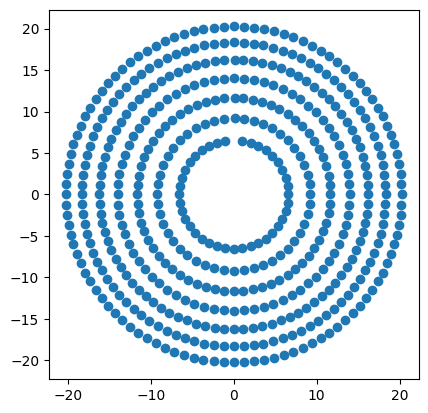

In [15]:
plt.scatter(sensor_pos_interp[0,:].cpu(),sensor_pos_interp[1,:].cpu())
plt.gca().set_aspect('equal')
print(sensor_pos_interp.shape)

In [16]:
## Simulation
def voxelize_spheres(rsphere, Rs, grid_size=128, bounding_box=2e-3):
    """
    Voxelizes spheres into a 3D grid.

    Parameters:
        rsphere (torch.Tensor): Tensor of shape (N, 3) with sphere centers in meters.
        Rs (torch.Tensor): Tensor of shape (N,) with sphere radii in meters.
        grid_size (int): Size of the 3D voxel grid (default: 128).
        bounding_box (float): Size of the bounding box in meters (default: 2e-3).

    Returns:
        torch.Tensor: 3D voxel grid of shape (grid_size, grid_size, grid_size).
    """
    # Compute voxel size
    voxel_size = bounding_box / grid_size

    # Create a 3D grid
    x = torch.linspace(-bounding_box / 2, bounding_box / 2, grid_size)
    y = torch.linspace(-bounding_box / 2, bounding_box / 2, grid_size)
    z = torch.linspace(-bounding_box / 2, bounding_box / 2, grid_size)
    grid_x, grid_y, grid_z = torch.meshgrid(x, y, z, indexing="ij")
    grid_x = grid_x.to(device)
    grid_y = grid_y.to(device)
    grid_z = grid_z.to(device)

    # Initialize a 3D voxel grid
    voxels = torch.zeros((grid_size, grid_size, grid_size), dtype=torch.float32, device=rsphere.device)

    # Compute voxelization
    for i in range(rsphere.shape[0]):
        # Sphere center and radius
        center = rsphere[i]
        radius = Rs[i]

        # Compute squared distances from the grid points to the sphere center
        dist_squared = (
            (grid_x - center[0])**2 +
            (grid_y - center[1])**2 +
            (grid_z - center[2])**2
        )

        # Mark voxels within the sphere's radius
        voxels += (dist_squared <= radius**2).float()

    # Normalize voxels for visualization (clip to 1 as some areas may overlap)
    voxels = torch.clamp(voxels, 0, 1)

    return voxels


# make them a network
def steep_sigmoid(r,alpha=1e6): # approximator for unit step U(r)
    return torch.sigmoid(alpha*r)

# def steep_sigmoid(r):
#     return torch.erf(r*0.1)

def p_init(r, pmag,Rs):
    # the p_init need multiplier so that the signal may match with the actual observation
    return pmag * steep_sigmoid(r) * steep_sigmoid(-r + Rs) * 1e3

def p_init_2d(r, pmag,Rs):
    # the p_init need multiplier so that the signal may match with the actual observation
    return pmag * steep_sigmoid(r + Rs/2) * steep_sigmoid(-r + Rs/2) * 1e3


def get_time_signal(t,r,vs,Rs,pmag):
    first_term      =  (r + vs*t) * p_init( r + vs*t,pmag,Rs) / (2*r) # (r + vs*t) *
    
    second_term     =  p_init(-r + vs*t,pmag,Rs) / (2*r) # (r - vs*t) * 
    third_term      =  p_init( r - vs*t,pmag,Rs) / (2*r) # (r - vs*t) * 

    second_term    *= (r - vs*t)
    third_term     *= (r - vs*t)

    pressure        =  second_term + third_term

    return pressure, second_term, third_term


def get_time_signal_2d(t,r,vs,Rs,pmag):
    pressure        =  0.5*p_init_2d(r - vs*t,pmag,Rs) + 0.5*p_init_2d(r + vs*t,pmag,Rs)
    return pressure

class ForwardModel(nn.Module):
    def __init__(self, sensor_pos, vs, Fs,start_t,end_t,psf,rimage,device):
        super(ForwardModel, self).__init__()
        self.sensor_pos = sensor_pos
        self.vs = vs
        self.Fs = Fs
        self.start_t = start_t
        self.end_t = end_t
        self.psf = psf
        # self.rimage = rimage
        self.device = device

    def forward(self, rsphere, Rs,pmag):
        rsensor = self.sensor_pos.T * 1e-3
        rs      = torch.cdist(rsphere.unsqueeze(0),rsensor.unsqueeze(0)).squeeze(0)
        t       = torch.arange(self.start_t,self.end_t) * (1/self.Fs)
        t       = t.to(self.device)

        rsgrid_mult,tgrid_mult  = torch.meshgrid(rs.flatten(),t,indexing='ij')
        rsgrid_mult             = rsgrid_mult.reshape(rs.shape[0],rs.shape[1],len(t))
        tgrid_mult              = tgrid_mult.reshape(rs.shape[0],rs.shape[1],len(t))

        traces,second_term,third_term  = get_time_signal(tgrid_mult,rsgrid_mult,self.vs,Rs.unsqueeze(-1).unsqueeze(-1),pmag.unsqueeze(-1).unsqueeze(-1))
        traces_bp                      = get_time_signal_2d(tgrid_mult,rsgrid_mult,self.vs,Rs.unsqueeze(-1).unsqueeze(-1),pmag.unsqueeze(-1).unsqueeze(-1))
        # everything ideally propagates as N-shape
        # print(traces.shape)
        if self.psf != None:
            AA = F.conv1d(traces.sum(0).unsqueeze(1),self.psf[:-1].unsqueeze(0).unsqueeze(0).to(self.device),padding='same').squeeze()
            return AA , traces.sum(0),traces_bp.sum(0)
        else:
            return traces.sum(0)

In [17]:
# get simulated rods
rimage = 1.5*1e-3 # in meters
vs     = cPA   # in meters

Simulator    = ForwardModel(
    sensor_pos=sensor_pos_interp,
    vs = vs,
    Fs = Fs,
    start_t = start_time_PA,
    end_t = end_time_PA,
    psf=torch.tensor(psf.real,dtype=torch.float),
    rimage = rimage,
    device=device
)
def get_simulated_random(nspheres,mean_radius,std_radius):

    # nspheres = 8
    rsphere  = torch.rand(nspheres,3) * 2 * rimage - rimage
    # print(rsphere*1e3)
    # Rs = (torch.rand(nspheres)) * radius_max
    Rs = (torch.randn(nspheres) * std_radius ) + mean_radius # in meters
    Rs = abs(Rs)

    # cconvert the rsphere
    rsphere = rsphere.to(device)
    Rs = Rs.to(device)
    # radius of the sphere
    
    # pressure magnitude
    pmag    = torch.ones(rsphere.shape[0]).to(device)

    # this simulates the forward function
    # albeit all in pytorch and "seems" trainiable
    # the fact that the sigmoid involves a huge parameters to achieve sharpness of N-shape
    # making the network hardly trainable
    syntheticPAx2,syntheticPAx2_fullband,syntheticPAx2_bp = Simulator(rsphere,Rs,pmag)
    
    voxgt       = voxelize_spheres(rsphere,Rs,128,2*rimage)

    del rsphere, Rs, pmag

    return syntheticPAx2,syntheticPAx2_fullband,syntheticPAx2_bp

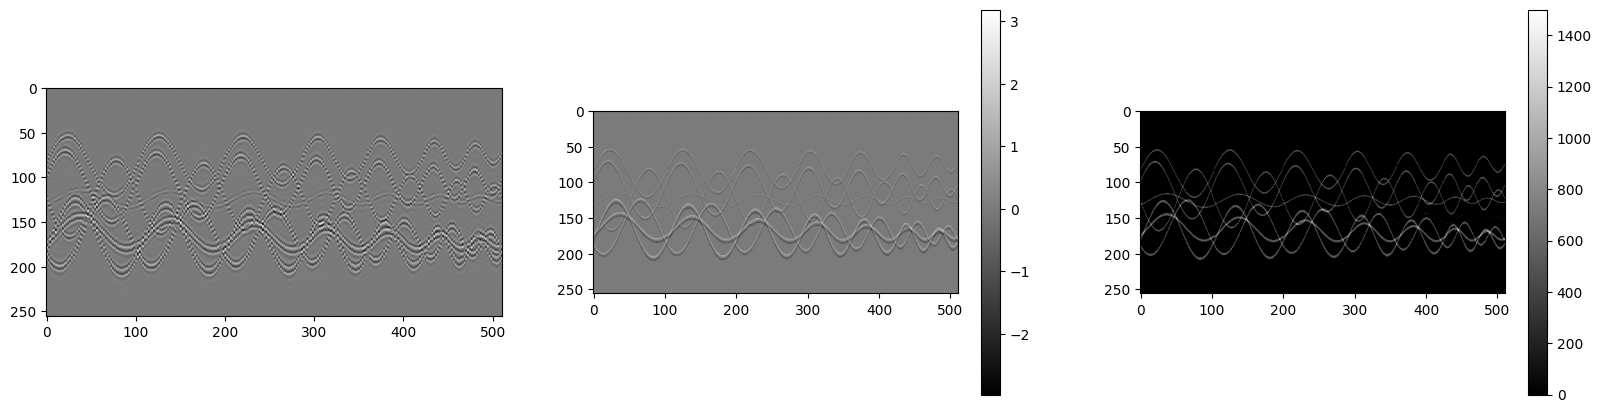

In [22]:
syntheticPAx2,syntheticPAx2_fullband,syntheticPAx2_bp =  get_simulated_random(8,50e-6,25e-6)
inp = F.interpolate(syntheticPAx2.cpu().T[:,::2].unsqueeze(0).unsqueeze(0),(syntheticPAx2.shape[1],syntheticPAx2.shape[0])).squeeze(0).squeeze(0)

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.imshow(inp,cmap='gray')
plt.subplot(132)
plt.imshow(syntheticPAx2_fullband.cpu().T,cmap='gray')
plt.colorbar()

plt.subplot(133)
plt.imshow(syntheticPAx2_bp.cpu().T,cmap='gray')
plt.colorbar()
plt.show()


# All model definition

## Sine activation function

In [24]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate    

class Sine(nn.Module):
    def forward(self, x):
        return torch.sin(x)#
    
def sine_init(m, omega=30):
    if isinstance(m, nn.Conv2d):
        with torch.no_grad():
            m.weight.uniform_(-1/omega, 1/omega)

from torch.nn.functional import interpolate



## Standard UNET Architecture

UNET was implemented from DNN Sinogram Super-resolution with modified activation function 

In [25]:
class DNNSinogramSR(nn.Module):

    def __init__(self, activ_func1, activ_func2,in_channels=1,out_channels=1, f = 32):

        super(DNNSinogramSR, self).__init__()
        # print('Old')
        # print('\n')
        self.f = f
        activ_func = activ_func1
        ksize = 3
        padsize = 1
        self.conv1_block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=self.f,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f, out_channels=self.f,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )
        self.max1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        

        
        self.conv2_block = nn.Sequential(
            nn.Conv2d(in_channels=f, out_channels=self.f*2,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*2, out_channels=self.f*2,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )
        self.max2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        

        # Conv block 3 - Down 3
        self.conv3_block = nn.Sequential(
            nn.Conv2d(in_channels=self.f*2, out_channels=self.f*4,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*4, out_channels=self.f*4,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )
        self.max3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        

        # Conv block 4 - Down 4
        self.conv4_block = nn.Sequential(
            nn.Conv2d(in_channels=self.f*4, out_channels=self.f*8,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*8, out_channels=self.f*8,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )
        self.max4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        

        # Conv block 5 - Down 5
        self.conv5_block = nn.Sequential(
            nn.Conv2d(in_channels=self.f*8, out_channels=self.f*16,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*16, out_channels=self.f*16,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )
        
        

        # Up 1
        self.up_1 = nn.ConvTranspose2d(in_channels=self.f*16, out_channels=self.f*8, kernel_size=2, stride=2)

        # Up Conv block 1
        self.conv_up_1 = nn.Sequential(
            nn.Conv2d(in_channels=self.f*16, out_channels=self.f*8,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*8, out_channels=self.f*8,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )

        # Up 2
        self.up_2 = nn.ConvTranspose2d(in_channels=self.f*8, out_channels=self.f*4, kernel_size=2, stride=2)

        # Up Conv block 2
        self.conv_up_2 = nn.Sequential(
            nn.Conv2d(in_channels=self.f*8, out_channels=self.f*4,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*4, out_channels=self.f*4,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )

        # Up 3
        self.up_3 = nn.ConvTranspose2d(in_channels=self.f*4, out_channels=self.f*2, kernel_size=2, stride=2)

        # Up Conv block 3
        self.conv_up_3 = nn.Sequential(
            nn.Conv2d(in_channels=self.f*4, out_channels=self.f*2,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*2, out_channels=self.f*2,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )

        # Up 4
        self.up_4 = nn.ConvTranspose2d(in_channels=self.f*2, out_channels=self.f, kernel_size=2, stride=2)

        # Up Conv block 4
        self.conv_up_4 = nn.Sequential(
            nn.Conv2d(in_channels=self.f*2, out_channels=self.f,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f, out_channels=self.f,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )

        # Final output
        # self.conv_final = nn.Conv2d(in_channels=32, out_channels=2,
        #                             kernel_size=1, padding=0, stride=1)

        self.conv_final = nn.Sequential(
            nn.Conv2d(in_channels=self.f, out_channels=out_channels, # use channels 2 for positive negative output
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func2,
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func2,
        )

    def forward(self, x):
        # print('input', x.shape)

        # Down 1
        x = self.conv1_block(x)
        # print('after conv1', x.shape)
        conv1_out = x  # Save out1
        conv1_dim = x.shape[2]
        x = self.max1(x)
        # print('before conv2', x.shape)

        # Down 2
        x = self.conv2_block(x)
        # print('after conv2', x.shape)
        conv2_out = x
        conv2_dim = x.shape[2]
        x = self.max2(x)
        # print('before conv3', x.shape)

        # Down 3
        x = self.conv3_block(x)
        # print('after conv3', x.shape)
        conv3_out = x
        conv3_dim = x.shape[2]
        x = self.max3(x)
        # print('before conv4', x.shape)

        # Down 4
        x = self.conv4_block(x)
        # print('after conv5', x.shape)
        conv4_out = x
        conv4_dim = x.shape[2]
        x = self.max4(x)
        # print('after conv4', x.shape)

        # Midpoint
        x = self.conv5_block(x)
        # print('mid', x.shape)

        # Up 1
        x = self.up_1(x)
        # print('up_1', x.shape)
        lower = int((conv4_dim - x.shape[2]) / 2)
        upper = int(conv4_dim - lower)
        conv4_out_modified = conv4_out[:, :, lower:upper, lower:upper]
        x = torch.cat([x, conv4_out_modified], dim=1)
        # print('after cat_1', x.shape)
        x = self.conv_up_1(x)
        # print('after conv_1', x.shape)

        # Up 2
        x = self.up_2(x)
        # print('up_2', x.shape)
        lower = int((conv3_dim - x.shape[2]) / 2)
        upper = int(conv3_dim - lower)
        conv3_out_modified = conv3_out[:, :, lower:upper, lower:upper]
        x = torch.cat([x, conv3_out_modified], dim=1)
        # print('after cat_2', x.shape)
        x = self.conv_up_2(x)
        # print('after conv_2', x.shape)

        # Up 3
        x = self.up_3(x)
        # print('up_3', x.shape)
        lower = int((conv2_dim - x.shape[2]) / 2)
        upper = int(conv2_dim - lower)
        conv2_out_modified = conv2_out[:, :, lower:upper, lower:upper]
        x = torch.cat([x, conv2_out_modified], dim=1)
        # print('after cat_3', x.shape)
        x = self.conv_up_3(x)
        # print('after conv_3', x.shape)

        # Up 4
        x = self.up_4(x)
        # print('up_4', x.shape)
        lower = int((conv1_dim - x.shape[2]) / 2)
        upper = int(conv1_dim - lower)
        conv1_out_modified = conv1_out[:, :, lower:upper, lower:upper]
        x = torch.cat([x, conv1_out_modified], dim=1)
        # print('after cat_4', x.shape)
        x = self.conv_up_4(x)
        # print('after conv_4', x.shape)

        # Final output
        x = self.conv_final(x)

        # if positive 2 channels
        # if (x.shape[1] == 2):
            # x = -x[:,0,:,:] + x[:,1,:,:]
            # x = x.unsqueeze(1)

        return x

In [26]:

net         = DNNSinogramSR(
    Sine(),
    Sine(),
    f=64
    ).to(device)


# net2         = DNNSinogramSR(
#     nn.ReLU(),
#     nn.ELU(),
#     ).to(device) # OG model

# the input is strided patch of 64 x 64 in size
summary(net.cpu(),input_size=(1,512,256),device='cpu')
patch_size = (64,64)
net = net.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 256]             640
              Sine-2         [-1, 64, 512, 256]               0
              Sine-3         [-1, 64, 512, 256]               0
              Sine-4         [-1, 64, 512, 256]               0
              Sine-5         [-1, 64, 512, 256]               0
              Sine-6         [-1, 64, 512, 256]               0
              Sine-7         [-1, 64, 512, 256]               0
              Sine-8         [-1, 64, 512, 256]               0
              Sine-9         [-1, 64, 512, 256]               0
             Sine-10         [-1, 64, 512, 256]               0
           Conv2d-11         [-1, 64, 512, 256]          36,928
             Sine-12         [-1, 64, 512, 256]               0
             Sine-13         [-1, 64, 512, 256]               0
             Sine-14         [-1, 64, 5

## UNET with Mirrored ReLU

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MirroredReLU(nn.Module):
    def __init__(self, kernel_size=3, padding=1, bias=True):
        super().__init__()

    def forward(self, x):
        x_pos = F.relu(x)
        x_neg = -F.relu(-x)
        x_cat = torch.cat([x_pos, x_neg], dim=1)  # (N, 2C, H, W)

        return x_cat
    
class AbsoluteReLU(nn.Module):
    def __init__(self, kernel_size=3, padding=1, bias=True):
        super().__init__()

    def forward(self, x):
        x_pos = F.relu(x)
        x_neg = F.relu(-x)
        x_cat = torch.cat([x_pos, x_neg], dim=1)  # (N, 2C, H, W)

        return x_cat



In [28]:
class UNETMODIFIED(nn.Module):

    def __init__(self, activ_func1, activ_func2,in_channels=1,out_channels=1, f = 32,multiplier=1):

        super(UNETMODIFIED, self).__init__()
        # print('Old')
        # print('\n')
        self.f = f
        activ_func = activ_func1
        ksize = 3
        padsize = 1
        if isinstance(activ_func1, AbsoluteReLU):
            multiplier = 2
            self.dualrelutail = nn.Conv2d(in_channels=out_channels*2, out_channels=out_channels,
                      kernel_size=ksize, padding=padsize, stride=1)
        elif isinstance(activ_func1, MirroredReLU):
            multiplier = 2
            self.dualrelutail = nn.Conv2d(in_channels=out_channels*2, out_channels=out_channels,
                      kernel_size=ksize, padding=padsize, stride=1)
        else:
            self.dualrelutail = None
        
        self.conv1_block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=self.f,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*multiplier, out_channels=self.f,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )
        self.max1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        

        
        self.conv2_block = nn.Sequential(
            nn.Conv2d(in_channels=f*multiplier, out_channels=self.f*2,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*2*multiplier, out_channels=self.f*2,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )
        self.max2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.conv2_block = nn.Sequential(
        #     nn.Conv2d(in_channels=f*multiplier, out_channels=self.f*2,
        #               kernel_size=ksize, padding=padsize, stride=1),
        #     activ_func,
        # )
        # self.max2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        

        # Conv block 3 - Down 3
        self.conv3_block = nn.Sequential(
            nn.Conv2d(in_channels=self.f*2*multiplier, out_channels=self.f*4,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*4*multiplier, out_channels=self.f*4,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )
        self.max3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        

        # Conv block 4 - Down 4
        self.conv4_block = nn.Sequential(
            nn.Conv2d(in_channels=self.f*4*multiplier, out_channels=self.f*8,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*8*multiplier, out_channels=self.f*8,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )
        self.max4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        

        # Conv block 5 - Down 5
        self.conv5_block = nn.Sequential(
            nn.Conv2d(in_channels=self.f*8*multiplier, out_channels=self.f*16,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*16*multiplier, out_channels=self.f*16,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )
        
        

        # Up 1
        self.up_1 = nn.ConvTranspose2d(in_channels=self.f*16*multiplier, out_channels=self.f*8*multiplier, kernel_size=2, stride=2)

        # Up Conv block 1
        self.conv_up_1 = nn.Sequential(
            nn.Conv2d(in_channels=self.f*16*multiplier, out_channels=self.f*8,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*8*multiplier, out_channels=self.f*8,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )

        # Up 2
        self.up_2 = nn.ConvTranspose2d(in_channels=self.f*8*multiplier, out_channels=self.f*4*multiplier, kernel_size=2, stride=2)

        # Up Conv block 2
        self.conv_up_2 = nn.Sequential(
            nn.Conv2d(in_channels=self.f*8*multiplier, out_channels=self.f*4,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*4*multiplier, out_channels=self.f*4,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )

        # Up 3
        self.up_3 = nn.ConvTranspose2d(in_channels=self.f*4*multiplier, out_channels=self.f*2*multiplier, kernel_size=2, stride=2)

        # Up Conv block 3
        self.conv_up_3 = nn.Sequential(
            nn.Conv2d(in_channels=self.f*4*multiplier, out_channels=self.f*2,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*2*multiplier, out_channels=self.f*2,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )

        # Up 4
        self.up_4 = nn.ConvTranspose2d(in_channels=self.f*2*multiplier, out_channels=self.f*multiplier, kernel_size=2, stride=2)

        # Up Conv block 4
        self.conv_up_4 = nn.Sequential(
            nn.Conv2d(in_channels=self.f*2*multiplier, out_channels=self.f,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
            nn.Conv2d(in_channels=self.f*multiplier, out_channels=self.f,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func,
        )

        # Final output
        # self.conv_final = nn.Conv2d(in_channels=32*multiplier, out_channels=2,
        #                             kernel_size=1, padding=0, stride=1)

        self.conv_final = nn.Sequential(
            nn.Conv2d(in_channels=self.f*multiplier, out_channels=out_channels, # use channels 2 for positive negative output
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func2,
            nn.Conv2d(in_channels=out_channels*multiplier, out_channels=out_channels,
                      kernel_size=ksize, padding=padsize, stride=1),
            activ_func2,
        )

    def forward(self, x):
        # print('input', x.shape)

        # Down 1
        x = self.conv1_block(x)
        # print('after conv1', x.shape)
        conv1_out = x  # Save out1
        conv1_dim = x.shape[2]
        x = self.max1(x)
        # print('before conv2', x.shape)

        # Down 2
        x = self.conv2_block(x)
        # print('after conv2', x.shape)
        conv2_out = x
        conv2_dim = x.shape[2]
        x = self.max2(x)
        # print('before conv3', x.shape)

        # Down 3
        x = self.conv3_block(x)
        # print('after conv3', x.shape)
        conv3_out = x
        conv3_dim = x.shape[2]
        x = self.max3(x)
        # print('before conv4', x.shape)

        # Down 4
        x = self.conv4_block(x)
        # print('after conv4', x.shape)
        conv4_out = x
        conv4_dim = x.shape[2]
        x = self.max4(x)
        # print('after conv4', x.shape)

        # Midpoint
        x = self.conv5_block(x)
        # print('mid', x.shape)

        # Up 1
        x = self.up_1(x)
        # print('up_1', x.shape)
        lower = int((conv4_dim - x.shape[2]) / 2)
        upper = int(conv4_dim - lower)
        conv4_out_modified = conv4_out[:, :, lower:upper, lower:upper]
        x = torch.cat([x, conv4_out_modified], dim=1)
        # print('after cat_1', x.shape)
        x = self.conv_up_1(x)
        # print('after conv_1', x.shape)

        # Up 2
        x = self.up_2(x)
        # print('up_2', x.shape)
        lower = int((conv3_dim - x.shape[2]) / 2)
        upper = int(conv3_dim - lower)
        conv3_out_modified = conv3_out[:, :, lower:upper, lower:upper]
        x = torch.cat([x, conv3_out_modified], dim=1)
        # print('after cat_2', x.shape)
        x = self.conv_up_2(x)
        # print('after conv_2', x.shape)

        # Up 3
        x = self.up_3(x)
        # print('up_3', x.shape)
        lower = int((conv2_dim - x.shape[2]) / 2)
        upper = int(conv2_dim - lower)
        conv2_out_modified = conv2_out[:, :, lower:upper, lower:upper]
        x = torch.cat([x, conv2_out_modified], dim=1)
        # print('after cat_3', x.shape)
        x = self.conv_up_3(x)
        # print('after conv_3', x.shape)

        # Up 4
        x = self.up_4(x)
        # print('up_4', x.shape)
        lower = int((conv1_dim - x.shape[2]) / 2)
        upper = int(conv1_dim - lower)
        conv1_out_modified = conv1_out[:, :, lower:upper, lower:upper]
        x = torch.cat([x, conv1_out_modified], dim=1)
        # print('after cat_4', x.shape)
        x = self.conv_up_4(x)
        # print('after conv_4', x.shape)

        # Final output
        x = self.conv_final(x)
        # print('test', x.shape)

        if self.dualrelutail is not None:
            x = self.dualrelutail(x)

        return x

In [29]:
net         = UNETMODIFIED(
    AbsoluteReLU(),
    AbsoluteReLU(),
    f=64,
    ).to(device)

dummy = torch.zeros((1,1,512,256))
summary(net.cpu(),input_size=(1,512,256),device='cpu')
net(dummy).shape

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 256]             640
      AbsoluteReLU-2        [-1, 128, 512, 256]               0
      AbsoluteReLU-3        [-1, 128, 512, 256]               0
      AbsoluteReLU-4        [-1, 128, 512, 256]               0
      AbsoluteReLU-5        [-1, 128, 512, 256]               0
      AbsoluteReLU-6        [-1, 128, 512, 256]               0
      AbsoluteReLU-7        [-1, 128, 512, 256]               0
      AbsoluteReLU-8        [-1, 128, 512, 256]               0
      AbsoluteReLU-9        [-1, 128, 512, 256]               0
     AbsoluteReLU-10        [-1, 128, 512, 256]               0
           Conv2d-11         [-1, 64, 512, 256]          73,792
     AbsoluteReLU-12        [-1, 128, 512, 256]               0
     AbsoluteReLU-13        [-1, 128, 512, 256]               0
     AbsoluteReLU-14        [-1, 128, 5

torch.Size([1, 1, 512, 256])

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenseBlock(nn.Module):
    def __init__(self,activ_func, in_channels, growth_rate,feature_map, num_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        channels = in_channels
        for _ in range(num_layers):
            self.layers.append(nn.Sequential(
                nn.Conv2d(channels, feature_map, kernel_size=1, padding=0, stride=1),
                activ_func,
                nn.Conv2d(feature_map, growth_rate, kernel_size=3, padding=1, stride=1),
                activ_func # the activation function
            ))
            channels += growth_rate

    def forward(self, x):
        features = [x]
        for layer in self.layers:
            out = layer(torch.cat(features, dim=1))
            features.append(out)
        return torch.cat(features, dim=1)


class Down(nn.Module):
    def __init__(self,activ_func, in_channels, growth_rate, feature_map, num_layers):
        super().__init__()
        self.dense = DenseBlock(activ_func,in_channels, growth_rate, feature_map, num_layers)
        out_channels = in_channels + growth_rate * num_layers
        
        self.pool = nn.MaxPool2d(2)
        self.out_channels = out_channels

    def forward(self, x):
        x = self.dense(x)
        x_pooled = self.pool(x)
        return x, x_pooled


class Up(nn.Module):
    def __init__(self, activ_func, in_channels, skip_channels, growth_rate, feature_map, num_layers):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.first_layer = nn.Sequential(
            nn.Conv2d(in_channels,in_channels//4,kernel_size=1,padding=0,stride=1),
            activ_func
        )
        self.dense = DenseBlock(activ_func,in_channels//4, growth_rate, feature_map, num_layers)
        self.out_channels = (in_channels//4) + growth_rate * num_layers

    def forward(self, x, skip):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        x = self.first_layer(x)
        return self.dense(x)


class FullyDenseUNet(nn.Module):
    def __init__(self, 
                 in_channels=1,
                 out_channels=1,
                 growth_rate=8,
                 feature_map=32,
                 num_layers=4,
                 activ_func  = nn.ReLU(),
                 activ_func2 = nn.ELU()):
        super().__init__()

        self.first_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=in_channels, kernel_size=3, padding=1, stride=1),
            activ_func,
        )

        self.enc1 = Down(activ_func,in_channels, growth_rate, feature_map,num_layers)  # output: c1
        self.enc2 = Down(activ_func,self.enc1.out_channels, growth_rate*2, feature_map,num_layers)  # c2
        self.enc3 = Down(activ_func,self.enc2.out_channels, growth_rate*4, feature_map,num_layers)  # c3
        self.enc4 = Down(activ_func,self.enc3.out_channels, growth_rate*8, feature_map,num_layers)  # c4
        # self.enc5 = Down(activ_func,self.enc4.out_channels, growth_rate*16, feature_map,num_layers)  # c4


        self.bottleneck_dense = DenseBlock(activ_func, self.enc4.out_channels, growth_rate*16, feature_map,num_layers)
        self.bottleneck_out_channels = self.enc4.out_channels + growth_rate*16 * num_layers

        # self.dec5 = Up(activ_func,self.bottleneck_out_channels, self.enc5.out_channels, growth_rate*16, feature_map, num_layers)
        self.dec4 = Up(activ_func,self.bottleneck_out_channels, self.enc4.out_channels, growth_rate*8, feature_map, num_layers)
        self.dec3 = Up(activ_func,self.dec4.out_channels, self.enc3.out_channels, growth_rate*4, feature_map, num_layers)
        self.dec2 = Up(activ_func,self.dec3.out_channels, self.enc2.out_channels, growth_rate*2, feature_map, num_layers)
        self.dec1 = Up(activ_func,self.dec2.out_channels, self.enc1.out_channels, growth_rate, feature_map, num_layers)

        self.conv_final = nn.Sequential(
            nn.Conv2d(in_channels=self.dec1.out_channels, out_channels=out_channels, # use channels 2 for positive negative output
                      kernel_size=3, padding=1, stride=1),
            activ_func2,
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels,
                      kernel_size=3, padding=1, stride=1),
            activ_func2,
        )

    def forward(self, x):
        xinp  = x
        x     = self.first_layer(x)
        x1, x = self.enc1(x)
        x2, x = self.enc2(x)
        x3, x = self.enc3(x)
        x4, x = self.enc4(x)
        # x5, x = self.enc5(x)

        x = self.bottleneck_dense(x)
        # print(x.shape)

        # x = self.dec5(x, x5)
        x = self.dec4(x, x4)
        x = self.dec3(x, x3)
        x = self.dec2(x, x2)
        x = self.dec1(x, x1)

        x = self.conv_final(x + xinp)

        return x


## Fully-dense UNET

In [31]:
net = FullyDenseUNet(in_channels=64,feature_map=64,growth_rate=16,activ_func=nn.ReLU(),activ_func2=nn.ELU())
dummy = torch.zeros((1,1,512,256))
summary(net.cpu(),input_size=(1,512,256),device='cpu')
net(dummy).shape

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 256]             640
              ReLU-2         [-1, 64, 512, 256]               0
              ReLU-3         [-1, 64, 512, 256]               0
              ReLU-4         [-1, 64, 512, 256]               0
              ReLU-5         [-1, 64, 512, 256]               0
              ReLU-6         [-1, 64, 512, 256]               0
              ReLU-7         [-1, 64, 512, 256]               0
              ReLU-8         [-1, 64, 512, 256]               0
              ReLU-9         [-1, 64, 512, 256]               0
             ReLU-10         [-1, 64, 512, 256]               0
             ReLU-11         [-1, 64, 512, 256]               0
             ReLU-12         [-1, 64, 512, 256]               0
             ReLU-13         [-1, 64, 512, 256]               0
             ReLU-14         [-1, 64, 5

torch.Size([1, 1, 512, 256])

## ResNET

In [32]:
class ResNet(nn.Module):

    def __init__(self,ich,och,ksz,padsz,activ_func,activ_func2,tail=False):
        super(ResNet, self).__init__()
        self.tail = tail
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=ich,out_channels=och,kernel_size=ksz,padding=padsz),
            activ_func
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=och,out_channels=och,kernel_size=ksz,padding=padsz),
            activ_func,
            nn.Conv2d(in_channels=och,out_channels=och,kernel_size=ksz,padding=padsz),
            activ_func,
            nn.Conv2d(in_channels=och,out_channels=och,kernel_size=ksz,padding=padsz),
            activ_func,
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=och,out_channels=och,kernel_size=ksz,padding=padsz),
            activ_func,
            nn.Conv2d(in_channels=och,out_channels=och,kernel_size=ksz,padding=padsz),
            activ_func,
            nn.Conv2d(in_channels=och,out_channels=och,kernel_size=ksz,padding=padsz),
            activ_func,
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=och,out_channels=och,kernel_size=ksz,padding=padsz),
            activ_func,
            nn.Conv2d(in_channels=och,out_channels=och,kernel_size=ksz,padding=padsz),
            activ_func,
            nn.Conv2d(in_channels=och,out_channels=och,kernel_size=ksz,padding=padsz),
            activ_func,
        )
        self.layer5 = nn.Conv2d(in_channels=och,out_channels=och,kernel_size=ksz,padding=padsz)
        self.layer6 = nn.Conv2d(in_channels=och,out_channels=ich,kernel_size=1,padding=0)

        # tail layer
        self.tail_layer = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=1,kernel_size=ksz,padding=padsz),
            activ_func2,
            nn.Conv2d(in_channels=1,out_channels=1,kernel_size=ksz,padding=padsz),
            activ_func2,
        )
    
    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x1 + x2)
        x4 = self.layer4(x2 + x3)
        x5 = self.layer5(x3 + x4)
        x6 = self.layer6(x + x5)
        if self.tail:
            x7 = self.tail_layer(x6)
            return x7
        else:
            return x6 

In [33]:
net = ResNet(1,64,(3,3),1,Sine(),Sine()).to(device)
dummy = torch.zeros((1,1,512,256))
summary(net.cpu(),input_size=(1,512,256),device='cpu')
net(dummy).shape

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 256]             640
              Sine-2         [-1, 64, 512, 256]               0
              Sine-3         [-1, 64, 512, 256]               0
              Sine-4         [-1, 64, 512, 256]               0
              Sine-5         [-1, 64, 512, 256]               0
            Conv2d-6         [-1, 64, 512, 256]          36,928
              Sine-7         [-1, 64, 512, 256]               0
              Sine-8         [-1, 64, 512, 256]               0
              Sine-9         [-1, 64, 512, 256]               0
             Sine-10         [-1, 64, 512, 256]               0
           Conv2d-11         [-1, 64, 512, 256]          36,928
             Sine-12         [-1, 64, 512, 256]               0
             Sine-13         [-1, 64, 512, 256]               0
             Sine-14         [-1, 64, 5

torch.Size([1, 1, 512, 256])

In [34]:
def add_noise_snr(x, snr_db):
    """
    Add Gaussian noise to a tensor to achieve a desired SNR (in dB).

    Args:
        x (torch.Tensor): Input tensor (signal).
        snr_db (float): Desired Signal-to-Noise Ratio in decibels.

    Returns:
        torch.Tensor: Noisy tensor.
    """
    signal_power = x.pow(2).mean()
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear
    noise_std = noise_power.sqrt()
    noise = torch.randn_like(x) * noise_std
    return x + noise

# Training

In [35]:
meanlist = [50e-6]
netnames = ["unet_relu_elu",    #0
            "unet_sine_sine",   #1
            "fdunet_relu_relu", #2
            "fdunet_relu_elu",  #3
            "fdunet_sine_sine", #4
            "resnet_relu",      #5
            "resnet_sine",      #6  
            "resnet_relu_elu",  #7
            "resnet_sine_sine", #8
            "unet_relu_sine",   #9
            "unet_absolute_relu_f64", # 10
            "fdunet_sine_sine_f32"] # 11

for iii in [1]:
    ii = 0
    nspheremax = 4
    if (iii % len(netnames)) == 0:
        net         = DNNSinogramSR(
            nn.ReLU(),
            nn.ELU(),
            f=64,
            ).to(device) # OG model
        
    elif (iii % len(netnames)) == 1:
        net         = DNNSinogramSR(
            Sine(),
            Sine(),
            f=64,
            ).to(device)
        # net2.apply(init_weights_kaiming)
    elif (iii % len(netnames)) == 2:
        net = FullyDenseUNet(in_channels=64,feature_map=64,growth_rate=16,activ_func=nn.ReLU(),activ_func2=nn.ReLU()).to(device)
    elif (iii % len(netnames)) == 3:
        net = FullyDenseUNet(in_channels=64,feature_map=64,growth_rate=16,activ_func=nn.ReLU(),activ_func2=nn.ELU()).to(device)
    elif (iii % len(netnames)) == 4:
        net = FullyDenseUNet(in_channels=64,feature_map=64,growth_rate=16,activ_func=Sine(),activ_func2=Sine()).to(device)
    elif (iii % len(netnames)) == 5:
        net = ResNet(1,64,(3,3),1,nn.ReLU(),nn.ELU()).to(device)
    elif (iii % len(netnames)) == 6:
        net = ResNet(1,64,(3,3),1,Sine(),Sine()).to(device)
    elif (iii % len(netnames)) == 7:
        net = ResNet(1,64,(3,3),1,nn.ReLU(),nn.ELU(),tail=True).to(device)
    elif (iii % len(netnames)) == 8:
        net = ResNet(1,64,(3,3),1,Sine(),Sine(),tail=True).to(device)
    elif (iii % len(netnames)) == 9:
        net         = DNNSinogramSR(
            nn.ReLU(),
            Sine(),
            f=64,
            ).to(device) # OG model
    elif (iii % len(netnames)) == 10:
        net         = UNETMODIFIED(
            AbsoluteReLU(),
            AbsoluteReLU(),
            f=64,
            ).to(device)
    elif (iii % len(netnames)) == 11:
        net = FullyDenseUNet(in_channels=32,feature_map=32,growth_rate=8,activ_func=Sine(),activ_func2=Sine()).to(device)
        


    optimizer    = torch.optim.Adam( net.parameters(),5e-5)


    STARTITER = 0
    MAXITER = STARTITER + 1
    tq = tqdm(range(STARTITER,MAXITER))
    lossval   = torch.zeros(MAXITER)
    lossval1  = torch.zeros(MAXITER)
    lossval2  = torch.zeros(MAXITER)
    lossval22 = torch.zeros(MAXITER)
    freqval   = torch.zeros(MAXITER)

    losstrain   = torch.zeros(MAXITER)


    # validation 1
    test,test_fullband,_ = get_simulated_random(nspheremax,meanlist[ii],45e-6)
    test_fullband = test_fullband / test_fullband.abs().max()
    test_fullband = test_fullband.to(device)
    test = test / test.abs().max()
    test = test.to(device)  
    test_interped = interpolate(test[::2,:].unsqueeze(0).unsqueeze(0),(test[::2,:].shape[0]*2,test.shape[1]),mode='bilinear')
  
    for i in (tq):
        net.train()
        # net2.train()
        optimizer.zero_grad()
        # optimizer2.zero_grad()
        syntheticPAx2,syntheticPAx2_fullband,syntheticPAx2_bp =  get_simulated_random(nspheremax,meanlist[ii],45e-6)


        syntheticPAx2 = syntheticPAx2 / syntheticPAx2.abs().max()
        syntheticPAx2_fullband = syntheticPAx2_fullband / syntheticPAx2_fullband.abs().max() # target output

        # input
        syntheticPAx1 = syntheticPAx2[::2,:] # I changed this previously
        syntheticPAx1 = add_noise_snr(syntheticPAx1,30)
        r

        # do interpolation
        syntheticPAx1 = interpolate(syntheticPAx1.unsqueeze(0).unsqueeze(0),(syntheticPAx1.shape[0]*2,syntheticPAx1.shape[1]),mode='bilinear')

        out  = net(syntheticPAx1.to(device))
        mseloss = nn.MSELoss()(out.squeeze(0).squeeze(0)[:-1,:] ,syntheticPAx2_fullband) 

        loss  = mseloss#+ lossdc * 1e-3
        losstrain[i] = loss.item()


        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            net.eval()
            out  = net(test_interped.to(device)) 
            valloss  = nn.MSELoss()(out.squeeze(0).squeeze(0)[:-1,:],test_fullband)
            lossval[i] = valloss.item()
            
            tq.set_postfix(train_error=f"{loss.item():.5f}",val_error=f"{valloss.item():.5f}")
    netname = netnames[iii % len(netnames)]
    torch.save( net.state_dict(), os.path.expanduser(f"./trained_model/{netname}.pth"))
    torch.save(lossval, os.path.expanduser(f"./trained_model/{netname}.lossval"))
    torch.save(losstrain, os.path.expanduser(f"./trained_model/{netname}.losstrain"))

    

 
    del net
    del optimizer
    with torch.no_grad():
        torch.cuda.empty_cache()
    torch.cuda.synchronize()  # optional, ensures GPU has finished

100%|██████████| 1/1 [00:00<00:00,  1.63it/s, train_error=0.02678, val_error=0.02385]
